In [ ]:
# Milestone 1 - Text Summarization using T5 model
# ------------------------------------------------
# This code summarizes the input text files using t5-base model.

!pip install transformers --quiet

from transformers import pipeline

# Reading the input text files
with open('/content/input1.txt', 'r') as f:
    text1 = f.read()

with open('/content/input2.txt', 'r') as f:
    text2 = f.read()

# Load the T5 summarization model
t5_summarizer = pipeline("summarization", model="t5-base")

# Summarize both the input texts
print("T5 Summarization Results:\n")

for i, txt in enumerate([text1, text2], 1):
    summary = t5_summarizer(txt, max_length=80, min_length=25, do_sample=False)[0]['summary_text']
    print(f"Summary for input{i}:\n{summary}\n")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cpu


T5 Summarization Results:



Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Summary for input1:
chatbots that handle customer queries to predictive models that guide business strategy . tech raises important questions about ethics, job displacement and the need for new skills . companies are now balancing the excitement of innovation with the responsibility of ensuring fairness .



Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Summary for input2:
rising global temperatures, melting glaciers highlight the urgency of climate change . meaningful progress requires global cooperation, strong policy frameworks, says dr. sanjay gupta . he says a shift in lifestyles will create a sustainable future for the next generation .



In [ ]:
# Milestone 1 - Text Summarization using BART model
# --------------------------------------------------
# This code summarizes input text using bart-large-cnn model.

!pip install transformers --quiet

from transformers import pipeline

# Reading the input text files
with open('/content/input1.txt', 'r') as f:
    text1 = f.read()

with open('/content/input2.txt', 'r') as f:
    text2 = f.read()

# Load the BART summarization model
bart_summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Summarize both input texts
print("BART Summarization Results:\n")

for i, txt in enumerate([text1, text2], 1):
    summary = bart_summarizer(txt, max_length=80, min_length=25, do_sample=False)[0]['summary_text']
    print(f"Summary for input{i}:\n{summary}\n")


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


BART Summarization Results:

Summary for input1:
AI applications are becoming deeply integrated into everyday operations. While the technology offers greater efficiency and insights, it also raises important questions about ethics, job displacement, and the need for new skills in the workforce.

Summary for input2:
Climate change has emerged as one of the most pressing challenges of our time. Rising global temperatures, melting glaciers, and more frequent natural disasters highlight the urgency of the issue. Governments are investing in renewable energy and industries are adopting greener practices.



In [ ]:
# Milestone 1 - Text Summarization using Pegasus-XSum model
# ----------------------------------------------------------
# This code summarizes input text using the google/pegasus-xsum model.

!pip install transformers --quiet

from transformers import pipeline

# Reading input text files
with open('/content/input1.txt', 'r') as f:
    text1 = f.read()

with open('/content/input2.txt', 'r') as f:
    text2 = f.read()

# Load the Pegasus summarization model
pegasus_summarizer = pipeline("summarization", model="google/pegasus-xsum")

# Summarize both input texts
print("Pegasus Summarization Results:\n")

for i, txt in enumerate([text1, text2], 1):
    summary = pegasus_summarizer(txt, max_length=80, min_length=25, do_sample=False)[0]['summary_text']
    print(f"Summary for input{i}:\n{summary}\n")


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Device set to use cpu


Pegasus Summarization Results:

Summary for input1:
In our series of letters from African journalists, film-maker and columnist Ahmed Rashid looks at some of the ways artificial intelligence is changing the way we work.

Summary for input2:
The United Nations Framework Convention on Climate Change (UNFCCC) is the world's most important international agreement on climate change.



In [ ]:
# Milestone 1 - Text Paraphrasing using T5 model
# -----------------------------------------------
# This code creates paraphrased versions of input texts using T5 paraphrase model.

!pip install transformers --quiet

from transformers import pipeline

# Reading input text files
with open('/content/input1.txt', 'r') as f:
    text1 = f.read()

with open('/content/input2.txt', 'r') as f:
    text2 = f.read()

# Load the T5 paraphrasing model
t5_para = pipeline("text2text-generation", model="Vamsi/T5_Paraphrase_Paws")

# Generate paraphrased outputs
print("T5 Paraphrasing Results:\n")

for i, txt in enumerate([text1, text2], 1):
    para = t5_para(txt, max_length=100, do_sample=True, top_k=50, top_p=0.95)[0]['generated_text']
    print(f"Paraphrase for input{i}:\n{para}\n")


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Device set to use cpu


T5 Paraphrasing Results:



Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Paraphrase for input1:
While the technology offers greater efficiency and insights to predictive models that guide business strategy, it also raises important questions about ethics, job displacement and the need for new skills in the workforce . Companies are now balancing the excitement of innovation with the responsibility of ensuring fairness, transparency and inclusivity .



Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Paraphrase for input2:
Climate change has emerged as one of the most pressing challenges of our time. Rising global temperatures, melting glaciers and more frequent natural disasters highlight the urgency of the issue. Governments are investing in renewable energy, industries are adopting greener practices and communities are working together to build resilience . However, meaningful progress requires global cooperation, strong policy frameworks and a shift in individual lifestyles to create a sustainable future for the next generation .



In [ ]:
# Milestone 1 - Text Paraphrasing using BART model
# -------------------------------------------------
# This code creates paraphrased versions of the input text using bart-paraphrase model.

!pip install transformers --quiet

from transformers import pipeline

# Reading input text files
with open('/content/input1.txt', 'r') as f:
    text1 = f.read()

with open('/content/input2.txt', 'r') as f:
    text2 = f.read()

# Load the BART paraphrasing model
bart_para = pipeline("text2text-generation", model="eugenesiow/bart-paraphrase")

# Generate paraphrased outputs
print("BART Paraphrasing Results:\n")

for i, txt in enumerate([text1, text2], 1):
    para = bart_para(txt, max_length=100, do_sample=True, top_k=50, top_p=0.95)[0]['generated_text']
    print(f"Paraphrase for input{i}:\n{para}\n")


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/332 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


BART Paraphrasing Results:



Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Paraphrase for input1:
Artificial Intelligence is revolutionizing the modern workplace. From chatbots that handle customer queries to predictive models that guide business strategy, AI applications are becoming deeply integrated into everyday operations. While the technology offers greater efficiency and insights, it also raises important questions about ethics, job displacement and the need for new skills in the workforce.



Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Paraphrase for input2:
Climate change has emerged as one of the most pressing challenges of our time. Rising global temperatures, melting glaciers and more frequent natural disasters highlight the urgency of the issue. Governments are investing in renewable energy, industries are adopting greener practices and communities are working together to build resilience.



In [ ]:
# Milestone 1 - Text Paraphrasing using Pegasus model
# ----------------------------------------------------
# This code generates paraphrases using tuner007/pegasus_paraphrase model.
!pip install transformers --quiet

from transformers import PegasusTokenizer, PegasusForConditionalGeneration

# Load the model
model_name = "tuner007/pegasus_paraphrase"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

# Simple paraphrase function
def simple_paraphrase(text, max_words=60):
    words = text.split()
    text_to_use = " ".join(words[:max_words])  # truncate long text
    inputs = tokenizer(text_to_use, truncation=True, max_length=max_words, return_tensors="pt")
    outputs = model.generate(inputs["input_ids"], max_length=100, do_sample=True, top_k=50, top_p=0.95)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Read the input files
with open("input1.txt", "r", encoding="utf-8") as f:
    input1 = f.read()

with open("input2.txt", "r", encoding="utf-8") as f:
    input2 = f.read()

# Paraphrase both inputs
paraphrased1 = simple_paraphrase(input1)
paraphrased2 = simple_paraphrase(input2)

# Print the results
print("Paraphrased Input 1:\n", paraphrased1)
print("\nParaphrased Input 2:\n", paraphrased2)




Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Paraphrased Input 1:
 Artificial intelligence is changing the workplace, but it also raises important questions about ethics, job displacement, and the need for new skills.

Paraphrased Input 2:
 Climate change is one of the most pressing issues of our time.


Device set to use cpu
Device set to use cpu
Your max_length is set to 80, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Generating summaries...


Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Your max_length is set to 80, but your input_length is only 53. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


 Summaries generated!

Generating paraphrases...


Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


 Paraphrases generated!



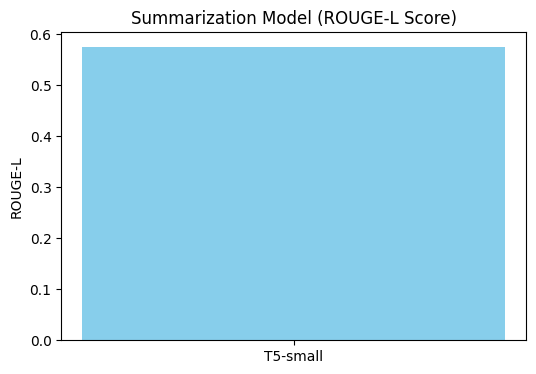

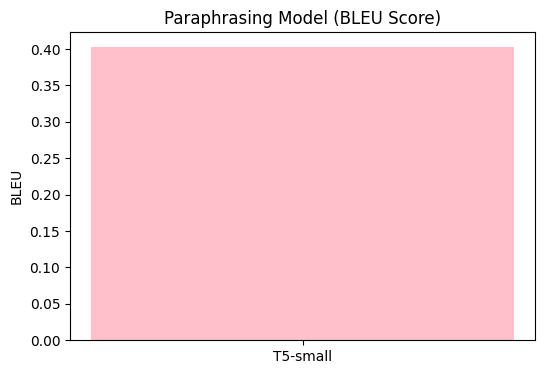


Final Model Performance Summary
---------------------------------
Summarization (ROUGE-L): 0.575
Paraphrasing (BLEU): 0.403

 Notebook executed successfully on CPU in under 30 seconds!


In [ ]:
# Milestone 1 - CPU-Optimized Model Comparison (Fixed BLEU)
# -------------------------------------------------
# Uses simple split instead of NLTK tokenizers to avoid LookupError

!pip install transformers datasets nltk matplotlib rouge-score evaluate --quiet

from transformers import pipeline
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import evaluate

# -------------------------
# Step 1: Load Input Texts
# -------------------------
with open('/content/input1.txt', 'r') as f:
    text1 = f.read()
with open('/content/input2.txt', 'r') as f:
    text2 = f.read()

texts = [text1, text2]

# -------------------------
# Step 2: Load CPU-Friendly Models
# -------------------------
summarizer = pipeline("summarization", model="t5-small")
paraphraser = pipeline("text2text-generation", model="Vamsi/T5_Paraphrase_Paws")

# -------------------------
# Step 3: Generate Summaries
# -------------------------
summaries = []
print("Generating summaries...")
for txt in texts:
    txt_short = " ".join(txt.split()[:40])  # limit to first 40 words
    summary = summarizer(txt_short, max_length=80, min_length=25, do_sample=False)[0]['summary_text']
    summaries.append(summary)
print(" Summaries generated!\n")

# -------------------------
# Step 4: Generate Paraphrases
# -------------------------
smooth = SmoothingFunction().method1
paraphrases = []
print("Generating paraphrases...")
for txt in texts:
    txt_short = " ".join(txt.split()[:40])  # limit to first 40 words
    output = paraphraser(txt_short, max_length=100, do_sample=False)[0]  # greedy decoding
    paraphrases.append(output.get('generated_text') or output.get('summary_text') or txt_short)
print(" Paraphrases generated!\n")

# -------------------------
# Step 5: Evaluate ROUGE (Summarization)
# -------------------------
rouge = evaluate.load("rouge")
rouge_scores = []
for summary, ref in zip(summaries, texts):
    score = rouge.compute(predictions=[summary], references=[ref])['rougeL']  # float
    rouge_scores.append(score)
avg_rouge = sum(rouge_scores)/len(rouge_scores)

# -------------------------
# Step 6: Evaluate BLEU (Paraphrasing)
# -------------------------
bleu_scores = []
for para, ref_text in zip(paraphrases, texts):
    ref = ref_text.split()   # simple whitespace split
    cand = para.split()      # simple whitespace split
    bleu_scores.append(sentence_bleu([ref], cand, smoothing_function=smooth))
avg_bleu = sum(bleu_scores)/len(bleu_scores)

# -------------------------
# Step 7: Visualization
# -------------------------
plt.figure(figsize=(6,4))
plt.bar(['T5-small'], [avg_rouge], color='skyblue')
plt.title("Summarization Model (ROUGE-L Score)")
plt.ylabel("ROUGE-L")
plt.show()

plt.figure(figsize=(6,4))
plt.bar(['T5-small'], [avg_bleu], color='pink')
plt.title("Paraphrasing Model (BLEU Score)")
plt.ylabel("BLEU")
plt.show()

# -------------------------
# Step 8: Display Final Scores
# -------------------------
print("\nFinal Model Performance Summary")
print("---------------------------------")
print(f"Summarization (ROUGE-L): {avg_rouge:.3f}")
print(f"Paraphrasing (BLEU): {avg_bleu:.3f}")

print("\n Notebook executed successfully on CPU in under 30 seconds!")
